# MultiLens line-of-sight substructure impact

### this notebooks analyses the impact of LOS structure at the Einstein radius and its impact on the observables and convergence field

In [1]:
from MultiLens.lens_assembly import LensAssembly
from MultiLens.Profiles.point_mass import PointMass
from MultiLens.lens_object import LensObject
from MultiLens.Cosmo.cosmo import CosmoProp
import MultiLens.Utils.utils as utils
from MultiLens.MultiLens import MultiLens
from MultiLens.Profiles.gaussian import Gaussian
from MultiLens.numerics import Numerics
import MultiLens.Utils.constants as const
from MultiLens.Utils.halo_param import HaloParam


import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="dark")
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable
cmap = sns.cubehelix_palette(start=0, light=1, as_cmap=True)

In [2]:
lensAssembly = LensAssembly()
cosmo = CosmoProp()
multiLens = MultiLens()
gaussian = Gaussian()
numerics = Numerics()
haloParam = HaloParam()

## choice of configuration

In [11]:
lens_type = 'SIS' # 'NFW', 'SIS'

z_lens = 0.5
z_source = 1.1

z_array = np.linspace(0.01, 1, 5)
pos_x_main = 0
pos_y_main = 0
r = 0.43
theta = np.pi/4
pos_x_sub = r*np.sin(theta)
pos_y_sub = r*np.cos(theta)
sigma_v_main = 200*1000.
sigma_v_sub = 35*1000.

mass_main = 10**11
mass_sub = 10**9

sigma_source = 0.05*const.arcsec
x_array, y_array = utils.make_grid(200, 0.007)

## define the lenses

In [12]:
kappa_full_list = []
kappa_born_list = []
mag_full_list = []
mag_born_list = []
Dds_0 = cosmo.D_xy(z_lens, z_source)

for i in range(len(z_array)):
    z = z_array[i]
    Dds = cosmo.D_xy(z, z_source)
    factor = Dds_0/Dds
    lensObject = LensObject(redshift=z, type=lens_type, approximation='weak', main=False)
    if lens_type == 'point_mass':
        kwargs_profile = {'mass': mass_sub*factor, 'pos_x': pos_x_sub, 'pos_y': pos_y_sub}
    elif lens_type=='NFW':
        r200, rho_s, Rs, c = haloParam.profileMain(mass_sub*factor, z)
        kwargs_profile = {'rho_s': rho_s, 'Rs': Rs, 'pos_x': pos_x_sub, 'pos_y': pos_y_sub}
    elif lens_type == 'SIS':
        kwargs_profile = {'sigma_v': sigma_v_sub*np.sqrt(factor), 'pos_x': pos_x_sub, 'pos_y': pos_y_sub}
    lensObject.add_info('kwargs_profile', kwargs_profile)
    lensAssembly.add_lens(lensObject)

    lensObject = LensObject(redshift=z_lens, type=lens_type, approximation='weak', main=True)
    if lens_type == 'point_mass':
        kwargs_profile = {'mass': mass_main, 'pos_x': pos_x_main, 'pos_y': pos_y_main}
    elif lens_type=='NFW':
        r200, rho_s, Rs, c = haloParam.profileMain(mass, z)
        kwargs_profile = {'rho_s': rho_s, 'Rs': Rs, 'pos_x': pos_x_main, 'pos_y': pos_y_main}
    elif lens_type == 'SIS':
        kwargs_profile = {'sigma_v': sigma_v_main, 'pos_x': pos_x_main, 'pos_y': pos_y_main}
    lensObject.add_info('kwargs_profile', kwargs_profile)
    lensAssembly.add_lens(lensObject)

    beta_x_full, beta_y_full = multiLens.full_ray_tracing(lensAssembly, z_source, x_array, y_array)
    beta_x_born, beta_y_born = multiLens.born_ray_tracing(lensAssembly, z_source, x_array, y_array)

    flux_full = gaussian.function(beta_x_full, beta_y_full, amp=1, sigma_x=sigma_source, sigma_y=sigma_source, center_x=0, center_y=0)
    flux_born = gaussian.function(beta_x_born, beta_y_born, amp=1, sigma_x=sigma_source, sigma_y=sigma_source, center_x=0, center_y=0)

    image_full = utils.array2image(flux_full)
    image_born = utils.array2image(flux_born)

    kappa_full = numerics.kappa(beta_x_full, beta_y_full, x_array, y_array)
    kappa_born = numerics.kappa(beta_x_born, beta_y_born, x_array, y_array)
    kappa_full_list.append(kappa_full)
    kappa_born_list.append(kappa_born)
    mag_full = numerics.magnification(beta_x_full, beta_y_full, x_array, y_array)
    mag_born = numerics.magnification(beta_x_born, beta_y_born, x_array, y_array)
    mag_full_list.append(mag_full)
    mag_born_list.append(mag_born)
    lensAssembly.clear()

LensAssembly class cleared. No lens object specified.
LensAssembly class cleared. No lens object specified.
LensAssembly class cleared. No lens object specified.
LensAssembly class cleared. No lens object specified.
LensAssembly class cleared. No lens object specified.


## numerical mapps

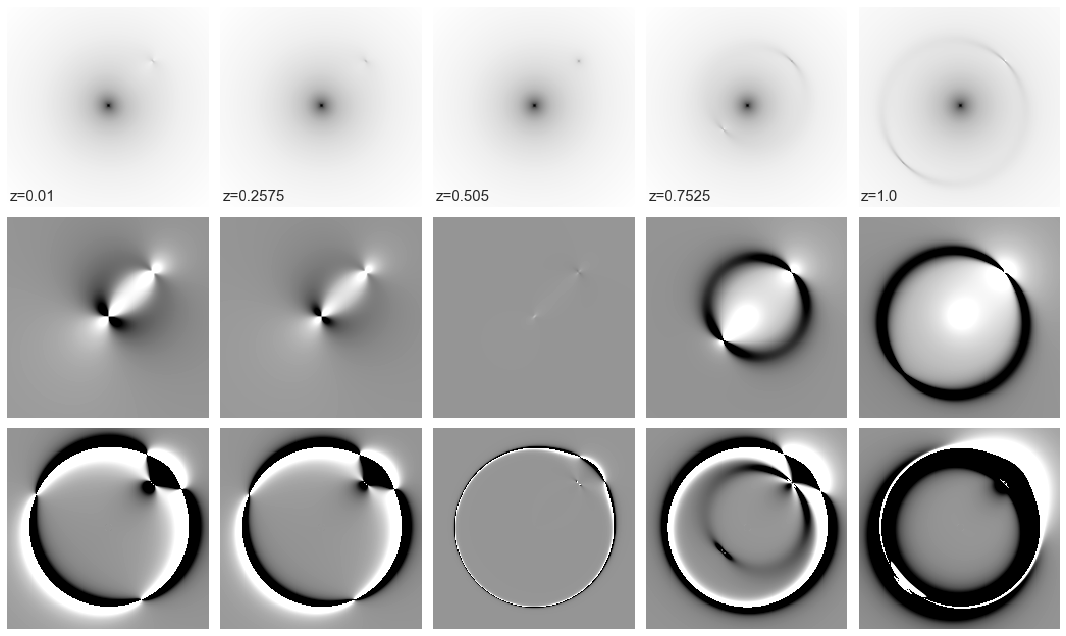

In [14]:
n = len(kappa_born_list)
f, axes = plt.subplots(3, n, figsize=(n*3, 9), sharex=False, sharey=False)

for i in range(n):
    kappa_full = kappa_full_list[i]
    kappa_born = kappa_born_list[i]
    mag_full = mag_full_list[i]
    mag_born = mag_born_list[i]
    z = z_array[i]
    
    ax = axes[0][i]
    ax.text(2, 6, "z=%s"%(z), fontsize=15)
    im=ax.matshow(np.log10(kappa_full),origin='lower')#, vmin=0, vmax=1)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)

    ax = axes[1][i]
    im=ax.matshow(kappa_full-kappa_born,origin='lower', vmin=-0.1, vmax=0.1)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    
    ax = axes[2][i]
    im=ax.matshow((np.abs(mag_full)-np.abs(mag_born)),origin='lower', vmin=-1, vmax=1)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)

f.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)
#plt.savefig('/Users/sibirrer/Cosmology/Strong_Lensing/Papers/MultiStrong/substructure_z.pdf', format='pdf')
plt.show()

In [6]:
# kappa mapps vs projected mass density

In [7]:
# magnification ratios of point-like sources (compare between different models)